In [1]:
%matplotlib inline
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation
from sklearn.metrics import pairwise_distances
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img_on_surf, view_img
from nilearn.image import concat_imgs
from nilearn.image import load_img
from nilearn.image import resample_to_img

/home/local/TU/tul04056/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
subjects = [105,106,107,108,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124]

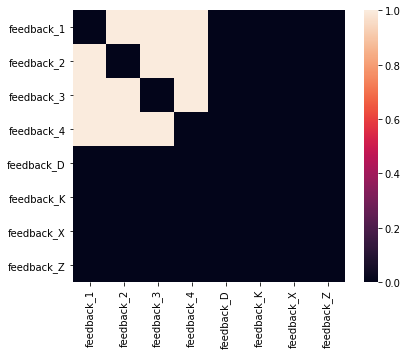

In [3]:
# M1
condition = ["feedback_1","feedback_2","feedback_3","feedback_4","feedback_D","feedback_K","feedback_X","feedback_Z"]
M1 = np.zeros((len(condition),len(condition)))
M1[np.diag_indices(len(condition))] = 1
M1[0,1] = 1
M1[0,2] = 1
M1[0,3] = 1
M1[1,2] = 1
M1[1,3] = 1
M1[2,3] = 1
M1 = Adjacency(M1, matrix_type = 'distance', labels = condition)
M1.plot()

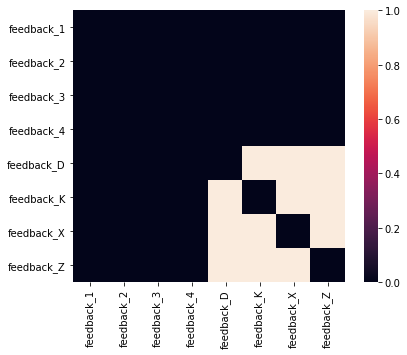

In [4]:
# M2
M2 = np.zeros((len(condition),len(condition)))
M2[np.diag_indices(len(condition))] = 1
M2[4,5] = 1
M2[4,6] = 1
M2[4,7] = 1
M2[5,6] = 1
M2[5,7] = 1
M2[6,7] = 1
M2 = Adjacency(M2, matrix_type = 'distance', labels = condition)
M2.plot()

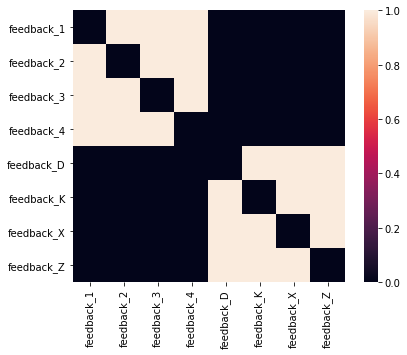

In [5]:
# M3
M3 = np.zeros((len(condition),len(condition)))
M3[np.diag_indices(len(condition))] = 1
M3[4,5] = 1
M3[4,6] = 1
M3[4,7] = 1
M3[5,6] = 1
M3[5,7] = 1
M3[6,7] = 1
M3[0,1] = 1
M3[0,2] = 1
M3[0,3] = 1
M3[1,2] = 1
M3[1,3] = 1
M3[2,3] = 1
M3 = Adjacency(M3, matrix_type = 'distance', labels = condition)
M3.plot()

/home/local/TU/tul04056/anaconda3/lib/python3.8/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


(128, 128, 30)


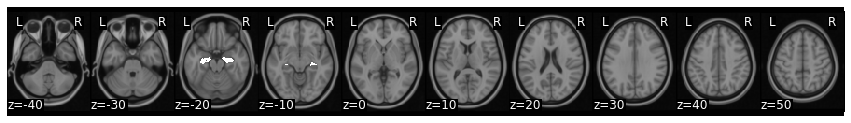

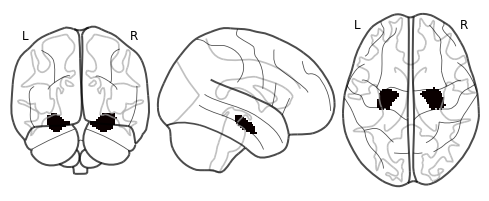

In [6]:
mask_path1 = '/data/projects/ru-highres/masks/a_hpc.nii.gz'
template = load_img('/data/projects/ru-highres/masks/bg_image.nii')
resampled_roi1 = resample_to_img(mask_path1,template)
print(resampled_roi1.shape)
mask1 = Brain_Data(resampled_roi1)
mask1 = mask1.threshold(upper = 0.95, binarize=True, coerce_nan=True)
mask1.plot()
plot_glass_brain(mask1.to_nifti())

/home/local/TU/tul04056/anaconda3/lib/python3.8/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


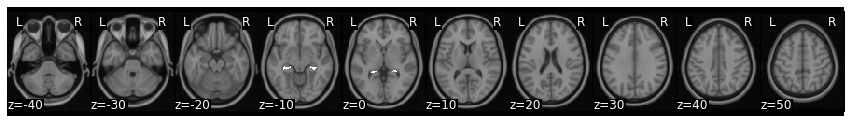

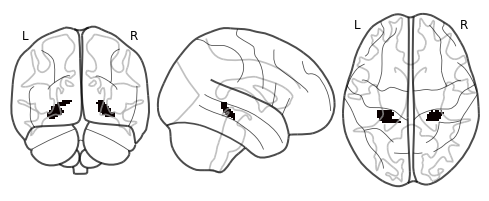

In [7]:
mask_path2 = '/data/projects/ru-highres/masks/p_hpc.nii.gz'
template = load_img('/data/projects/ru-highres/masks/bg_image.nii')
resampled_roi2 = resample_to_img(mask_path2,template)
mask2 = Brain_Data(resampled_roi2)
mask2 = mask2.threshold(upper = 0.95, binarize=True, coerce_nan=True)
mask2.plot()
plot_glass_brain(mask2.to_nifti())

/home/local/TU/tul04056/anaconda3/lib/python3.8/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


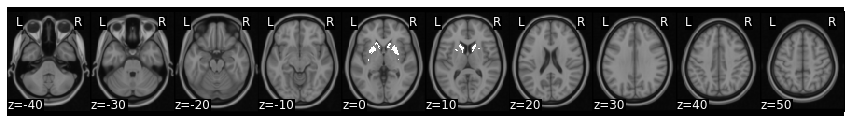

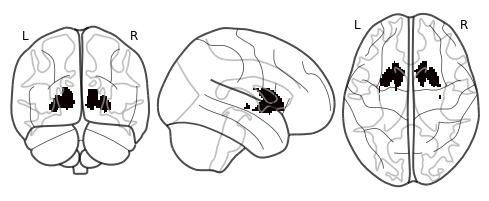

In [8]:
mask_path3 = '/data/projects/ru-highres/masks/executive_7sub.nii.gz'
template = load_img('/data/projects/ru-highres/masks/bg_image.nii')
resampled_roi3 = resample_to_img(mask_path3,template)
mask3 = Brain_Data(resampled_roi3)
mask3 = mask3.threshold(upper = 0.95, binarize=True, coerce_nan=True)
mask3.plot()
plot_glass_brain(mask3.to_nifti())

/home/local/TU/tul04056/anaconda3/lib/python3.8/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


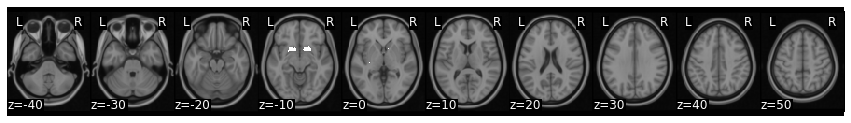

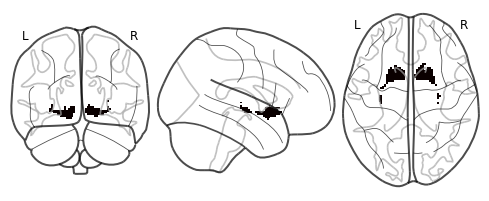

In [9]:
mask_path4 = '/data/projects/ru-highres/masks/limbic_7sub.nii.gz'
template = load_img('/data/projects/ru-highres/masks/bg_image.nii')
resampled_roi4 = resample_to_img(mask_path4,template)
mask4 = Brain_Data(resampled_roi4)
mask4 = mask4.threshold(upper = 0.95, binarize=True, coerce_nan=True)
mask4.plot()
plot_glass_brain(mask4.to_nifti())

nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])
0.5818573654517123
0.4525557286846651
0.8576900278702358
nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])
0.5926325018489662
0.4417805922874112
0.8576900278702358
nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])
0.6896087294242517
0.34480436471212583
0.8576900278702358
nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])
0.4956562742736809
0.5387568198626965
0.8576900278702358


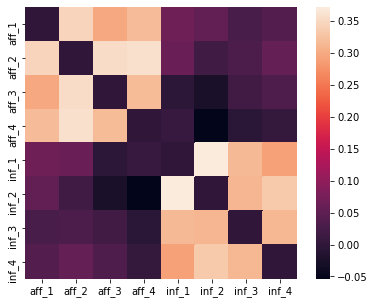

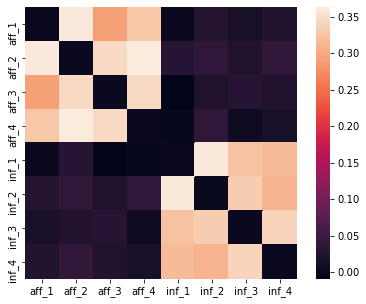

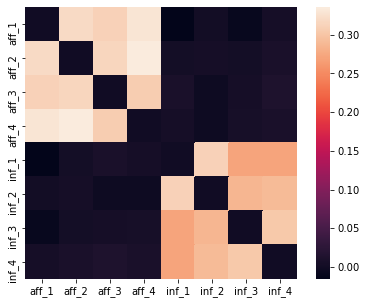

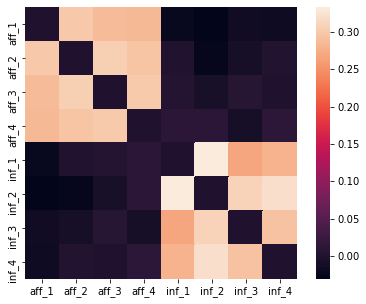

In [10]:
datapath = '/data/projects/ru-highres/derivatives/fsl/'

for m in [mask1,mask2,mask3,mask4]:
    print(m)
    feedback_pattern = []
    for sub in subjects:
        # create a list of beta maps per condition
        file_list9 = [os.path.join(datapath,"sub-"+str(sub),"L2_task-aff_model-01.gfeat","cope1.feat","stats","zstat1.nii.gz"),
                     os.path.join(datapath,"sub-"+str(sub),"L2_task-aff_model-01.gfeat","cope2.feat","stats","zstat1.nii.gz"),
                     os.path.join(datapath,"sub-"+str(sub),"L2_task-aff_model-01.gfeat","cope3.feat","stats","zstat1.nii.gz"),
                     os.path.join(datapath,"sub-"+str(sub),"L2_task-aff_model-01.gfeat","cope4.feat","stats","zstat1.nii.gz"),
                     os.path.join(datapath,"sub-"+str(sub),"L2_task-inf_model-03_subj.gfeat","cope1.feat","stats","zstat1.nii.gz"),
                     os.path.join(datapath,"sub-"+str(sub),"L2_task-inf_model-03_subj.gfeat","cope2.feat","stats","zstat1.nii.gz"),
                     os.path.join(datapath,"sub-"+str(sub),"L2_task-inf_model-03_subj.gfeat","cope3.feat","stats","zstat1.nii.gz"),
                     os.path.join(datapath,"sub-"+str(sub),"L2_task-inf_model-03_subj.gfeat","cope4.feat","stats","zstat1.nii.gz")]


        # put all the beta maps into a Brain_Data object
        beta = Brain_Data(file_list9)

        # compute pairwise correlation between each betamap's masked area
        sub_pattern_similarity = 1- beta.apply_mask(m).distance(metric = 'correlation')
        sub_pattern_similarity.labels = ["aff_1","aff_2","aff_3","aff_4","inf_1","inf_2","inf_3","inf_4"]
        feedback_pattern.append(sub_pattern_similarity)
             
    feedback_avg = Adjacency(feedback_pattern).mean(axis = 0)
    feedback_avg.labels =["aff_1","aff_2","aff_3","aff_4","inf_1","inf_2","inf_3","inf_4"]
    feedback_avg.plot()


    #correlate two matrices
    cross_task1 = feedback_avg.similarity(M1, metric = 'spearman', n_permute = 0,ignore_diagonal=True)
    cross_task_r1 = cross_task1['correlation']
    print(cross_task_r1)
    
    cross_task2 = feedback_avg.similarity(M2, metric = 'spearman', n_permute = 0, ignore_diagonal=True)
    cross_task_r2 = cross_task2['correlation']
    print(cross_task_r2)
    
    cross_task3 = feedback_avg.similarity(M3, metric = 'spearman', n_permute = 0, ignore_diagonal=True)
    cross_task_r3 = cross_task3['correlation']
    print(cross_task_r3)
    
